> 기말고사

In [15]:
import torch 
import matplotlib.pyplot as plt

## `1`. hi?hello!! (90점)

아래와 같은 데이터가 있다고 하자. 

In [112]:
txt = list('hi?hello!!')*100 
txt_x = txt[:-1]
txt_y = txt[1:]

In [113]:
txt_x[:5], txt_y[:5]

(['h', 'i', '?', 'h', 'e'], ['i', '?', 'h', 'e', 'l'])

`txt_x`와 `txt_y`를 이용하여 아래와 같은 순서로 다음문자를 예측하고 싶은 신경망을 설계하고 싶다.

`h` $\to$ `i` $\to$ `?` $\to$ `h` $\to$ `e` $\to$ `l` $\to$ `l` $\to$ `o` $\to$ `!` $\to$ `!` $\to$ `h` $\to$ `i` $\to$ `?` $\to$ `h` $\to$ `e` $\to$ $\dots$

***(1)-(6)*** 의 풀이에 공통적으로 필요한 과정 정리 

In [372]:
def f(txt,mapping):
    return [mapping[key] for key in txt] 
sig = torch.nn.Sigmoid()
soft = torch.nn.Softmax(dim=1)
tanh = torch.nn.Tanh()
mapping = {'!':0, '?':1,'h':2,'i':3,'e':4,'l':5,'o':6} 
x= torch.nn.functional.one_hot(torch.tensor(f(txt_x,mapping))).float().to("cuda:0")
y= torch.nn.functional.one_hot(torch.tensor(f(txt_y,mapping))).float().to("cuda:0")

`(1)` `torch.nn.RNN()`을 이용하여 다음문자를 예측하는 신경망을 설계하고 학습하라. 

(풀이)

In [373]:
rnn = torch.nn.RNN(7,8).to("cuda:0")
linr = torch.nn.Linear(8,7).to("cuda:0")
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(rnn.parameters())+list(linr.parameters()),lr=0.1)

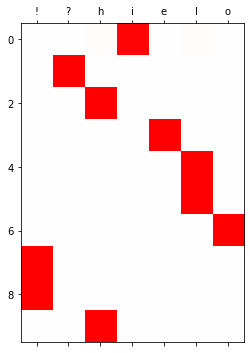

In [374]:
for epoc in range(100):
    ## 1
    hidden, hT = rnn(x) # _water 사실 생략할 수 있어요..
    output = linr(hidden)
    ## 2
    loss = loss_fn(output,y)
    ## 3
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
yhat=soft(output)    
plt.matshow(yhat.to("cpu").data[:10],cmap='bwr',vmin=-1,vmax=1)
plt.xticks(range(7),labels=['!','?','h','i','e','l','o']);

`(2)` `torch.nn.RNNCell()`을 이용하여 다음문자를 예측하는 신경망을 설계하고 학습하라. 

(풀이)

In [375]:
torch.manual_seed(43052)
rnncell = torch.nn.RNNCell(7,8).to("cuda:0")
linr = torch.nn.Linear(8,7).to("cuda:0")
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(rnncell.parameters())+list(linr.parameters()),lr=0.1)

In [376]:
for epoc in range(100):
    ## 1
    hidden = [] 
    ht = torch.zeros(8).to("cuda:0")
    for xt,yt in zip(x,y): 
        ht = rnncell(xt,ht) 
        hidden.append(ht) 
    hidden = torch.stack(hidden)
    output = linr(hidden)
    ## 2 
    loss = loss_fn(output,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

In [377]:
yhat = soft(output)
yhat[:10].to("cpu").detach().numpy().round(3)

array([[0.   , 0.005, 0.008, 0.972, 0.014, 0.001, 0.   ],
       [0.   , 0.997, 0.002, 0.   , 0.   , 0.001, 0.   ],
       [0.   , 0.001, 0.999, 0.   , 0.001, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.999, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 1.   , 0.   ],
       [0.   , 0.001, 0.   , 0.   , 0.   , 0.999, 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 1.   ],
       [0.999, 0.   , 0.   , 0.   , 0.   , 0.   , 0.001],
       [0.999, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.001, 0.998, 0.   , 0.   , 0.   , 0.   ]], dtype=float32)

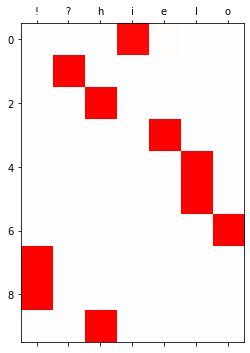

In [378]:
plt.matshow(yhat.to("cpu").data[:10],cmap='bwr',vmin=-1,vmax=1)
plt.xticks(range(7),labels=['!','?','h','i','e','l','o']);

`(3)` `torch.nn.Module`을 상속받은 클래스를 정의하고 (2)의 결과와 동일한 적합값이 나오는 신경망을 설계한 뒤 학습하라. (초기값을 적절하게 설정할 것) 

- class를 이용하지 않으면 점수없음. 
- torch.nn.RNN(), torch.nn.RNNCell() 을 이용한 네트워크를 학습시킬시 점수 없음. (초기값을 셋팅하는 용도로는 torch.nn.RNN(), torch.nn.RNNCell()을 코드에 포함시키는 것이 가능) 

(풀이)

In [379]:
class rNNCell(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.i2h = torch.nn.Linear(7,8)
        self.h2h = torch.nn.Linear(8,8) 
        self.tanh = torch.nn.Tanh()
    def forward(self,xt,ht):
        ht = self.tanh(self.i2h(xt)+self.h2h(ht))
        return ht

In [380]:
rnncell = rNNCell().to("cuda:0")
linr = torch.nn.Linear(8,7).to("cuda:0")
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(rnncell.parameters())+list(linr.parameters()),lr=0.1)

In [381]:
## 초기화의 설정을 위한 코드
torch.manual_seed(43052)
_rnncell = torch.nn.RNNCell(7,8).to("cuda:0")
_linr = torch.nn.Linear(8,7).to("cuda:0")
rnncell.i2h.weight.data = _rnncell.weight_ih.data 
rnncell.h2h.weight.data = _rnncell.weight_hh.data 
rnncell.h2h.bias.data = _rnncell.bias_hh.data
rnncell.i2h.bias.data = _rnncell.bias_ih.data
linr.weight.data = _linr.weight.data 
linr.bias.data = _linr.bias.data 

In [382]:
for epoc in range(100):
    ## 1
    hidden = [] 
    ht = torch.zeros(8).to("cuda:0")
    for xt,yt in zip(x,y): 
        ht = rnncell(xt,ht)
        ot = linr(ht) 
        hidden.append(ht) 
    hidden = torch.stack(hidden)
    output = linr(hidden) 
    ## 2 
    loss = loss_fn(output,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

In [383]:
yhat = soft(output)
yhat[:10].to("cpu").detach().numpy().round(3)

array([[0.   , 0.005, 0.008, 0.972, 0.014, 0.001, 0.   ],
       [0.   , 0.997, 0.002, 0.   , 0.   , 0.001, 0.   ],
       [0.   , 0.001, 0.999, 0.   , 0.001, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.999, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 1.   , 0.   ],
       [0.   , 0.001, 0.   , 0.   , 0.   , 0.999, 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 1.   ],
       [0.999, 0.   , 0.   , 0.   , 0.   , 0.   , 0.001],
       [0.999, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.001, 0.998, 0.   , 0.   , 0.   , 0.   ]], dtype=float32)

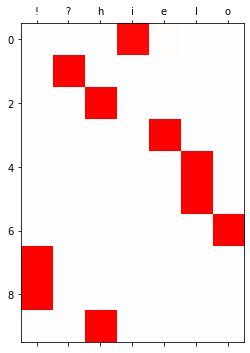

In [384]:
plt.matshow(yhat.to("cpu").data[:10],cmap='bwr',vmin=-1,vmax=1)
plt.xticks(range(7),labels=['!','?','h','i','e','l','o']);

`(4)` `torch.nn.LSTM()`을 이용하여 다음문자를 예측하는 신경망을 설계하고 학습하라. 

(풀이)

In [385]:
lstm = torch.nn.LSTM(7,4).to("cuda:0")
linr = torch.nn.Linear(4,7).to("cuda:0")
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(lstm.parameters())+list(linr.parameters()),lr=0.1)

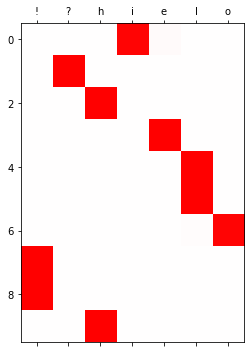

In [386]:
for epoc in range(100):
    ## 1
    hidden, (hT,cT) = lstm(x)
    output = linr(hidden)
    ## 2
    loss = loss_fn(output,y)
    ## 3
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
yhat=soft(output)    
plt.matshow(yhat.to("cpu").data[:10],cmap='bwr',vmin=-1,vmax=1)
plt.xticks(range(7),labels=['!','?','h','i','e','l','o']);

`(5)` `torch.nn.LSTMCell()`을 이용하여 다음문자를 예측하는 신경망을 설계하고 학습하라. 

(풀이)

In [437]:
torch.manual_seed(43052) 
lstmcell = torch.nn.LSTMCell(7,4).to("cuda:0")
linr = torch.nn.Linear(4,7).to("cuda:0")
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(lstmcell.parameters())+list(linr.parameters()),lr=0.1)

In [438]:
for epoc in range(100):
    ## 1
    hidden = []
    ht = torch.zeros(4).to("cuda:0")
    ct = torch.zeros(4).to("cuda:0")
    for xt,yt in zip(x,y): 
        ht,ct = lstmcell(xt,(ht,ct))
        hidden.append(ht) 
    hidden = torch.stack(hidden)
    output = linr(hidden)
    ## 2 
    loss = loss_fn(output,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

In [439]:
yhat = soft(output)
yhat[:10].to("cpu").detach().numpy().round(3)

array([[0.   , 0.014, 0.084, 0.081, 0.822, 0.   , 0.   ],
       [0.002, 0.91 , 0.   , 0.083, 0.003, 0.   , 0.001],
       [0.001, 0.   , 0.999, 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.001, 0.005, 0.072, 0.917, 0.004, 0.   ],
       [0.   , 0.   , 0.004, 0.   , 0.001, 0.995, 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.999, 0.001],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.999],
       [0.998, 0.001, 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.99 , 0.   , 0.006, 0.001, 0.   , 0.003, 0.   ],
       [0.007, 0.   , 0.992, 0.   , 0.   , 0.001, 0.   ]], dtype=float32)

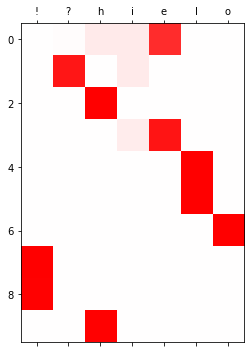

In [440]:
plt.matshow(yhat.to("cpu").data[:10],cmap='bwr',vmin=-1,vmax=1)
plt.xticks(range(7),labels=['!','?','h','i','e','l','o']);

`(6)` (5)의 결과와 동일한 적합값을 출력하는 신경망을 직접설계한 뒤 학습시켜라. (초기값을 적절하게 설정할 것) 

- class를 이용하지 않아도 무방함. 
- torch.nn.LSTM(), torch.nn.LSTMCell() 을 이용한 네트워크를 학습시킬시 점수 없음. (초기값을 셋팅하는 용도로는 torch.nn.LSTM(), torch.nn.LSTMCell()을 코드에 포함시키는 것은 가능) 

(풀이)

In [540]:
class lSTMCell(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.i2h = torch.nn.Linear(7,16)
        self.h2h = torch.nn.Linear(4,16) 
        self.tanh = torch.nn.Tanh()
    def forward(self,xt,past):
        ht,ct = past 
        ifgo = self.i2h(xt) + self.h2h(ht) 
        it = sig(ifgo[0:4])
        ft = sig(ifgo[4:8])
        gt = tanh(ifgo[8:12])
        ot = sig(ifgo[12:16])
        ct = ft*ct + it*gt
        ht = ot*self.tanh(ct) 
        return ht,ct

In [541]:
lstmcell = lSTMCell().to("cuda:0")
linr = torch.nn.Linear(4,7).to("cuda:0")
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(lstmcell.parameters())+list(linr.parameters()),lr=0.1)

In [542]:
# 초기값셋팅
torch.manual_seed(43052) 
_lstmcell = torch.nn.LSTMCell(7,4).to("cuda:0")
_linr = torch.nn.Linear(4,7).to("cuda:0")
lstmcell.i2h.weight.data = _lstmcell.weight_ih.data 
lstmcell.h2h.weight.data = _lstmcell.weight_hh.data 
lstmcell.i2h.bias.data = _lstmcell.bias_ih.data
lstmcell.h2h.bias.data = _lstmcell.bias_hh.data
linr.weight.data = _linr.weight.data 
linr.bias.data = _linr.bias.data 

In [543]:
for epoc in range(100):
    ## 1
    hidden = []     
    ht = torch.zeros(4).to("cuda:0")
    ct = torch.zeros(4).to("cuda:0")
    for xt,yt in zip(x,y): 
        ht,ct = lstmcell(xt,(ht,ct))
        hidden.append(ht) 
    hidden = torch.stack(hidden)
    output = linr(hidden) 
    ## 2 
    loss = loss_fn(output,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

In [544]:
yhat = soft(output)
yhat[:10].to("cpu").detach().numpy().round(3)

array([[0.   , 0.014, 0.084, 0.081, 0.822, 0.   , 0.   ],
       [0.002, 0.91 , 0.   , 0.083, 0.003, 0.   , 0.001],
       [0.001, 0.   , 0.999, 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.001, 0.005, 0.072, 0.917, 0.004, 0.   ],
       [0.   , 0.   , 0.004, 0.   , 0.001, 0.995, 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.999, 0.001],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.999],
       [0.998, 0.001, 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.99 , 0.   , 0.006, 0.001, 0.   , 0.003, 0.   ],
       [0.007, 0.   , 0.992, 0.   , 0.   , 0.001, 0.   ]], dtype=float32)

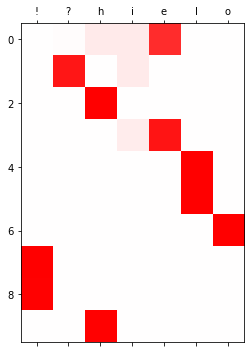

In [545]:
plt.matshow(yhat.to("cpu").data[:10],cmap='bwr',vmin=-1,vmax=1)
plt.xticks(range(7),labels=['!','?','h','i','e','l','o']);

## `2`. 다음을 읽고 참 거짓을 판단하여라. (10점) 

`(1)` LSTM은 RNN보다 장기기억에 유리하다. (**True**)

`(2)` `torch.nn.Embedding(num_embeddings=2,embedding_dim=1)`와 `torch.nn.Linear(in_features=1,out_features=1)`의 학습가능한 파라메터수는 같다. (**True**)

`(3)` 아래와 같은 네트워크를 고려하자. 

```Python
net = torch.nn.Linear(1,1)
```

차원이 (n,1) 인 임의의 텐서에 대하여 net(x)와 net.forward(x)의 출력결과는 같다. (**True**)

`(4)` 아래와 같이 a,b,c,d 가 반복되는 문자열이 반복되는 자료에서 다음문자열을 맞추는 과업을 수행하기 위해서는 반드시 순환신경망의 형태로 설계해야만 한다. (**False**) --> 오타로인하여 문제삭제

```
a,b,c,d,a,b,c,d,...
```

`(5)` RNN 혹은 LSTM 으로 신경망을 설계할 시 손실함수는 항상 `torch.nn.CrossEntropyLoss` 를 사용해야 한다. (**False**)